In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip -q install clu
    %load_ext tensorboard
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers'
    # %tensorboard \
        # --logdir '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers/runs' \

In [2]:
from datetime import datetime as dt
from itertools import chain
import os
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import optax
from flax.training import train_state


from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
import hephaestus_jax as hp
from jax.config import config

# config.update("jax_debug_nans", True)

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("../data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
dataset = hp.TabularDS(df, target_column="price")

In [4]:
mtm = hp.MTM(dataset, n_heads=4)
trm = hp.TRM(dataset, n_heads=4)

In [5]:
batch_size = 3
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = hp.mask_tensor(test_num, dataset)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = hp.mask_tensor(test_cat, dataset)

In [6]:
root_key = random.PRNGKey(0)
main_key, params_key, dropout_key = random.split(root_key, 3)

mtm_variables = mtm.init(
    params_key,
    test_num_mask,
    test_cat_mask,
)

# trm_variables = trm.init(
#     rngs,
#     test_num_mask,
#     test_cat_mask,
# )

In [7]:
# regression_out = trm.apply(
#     {"params": trm_variables["params"]},
#     test_num_mask,
#     test_cat_mask,
#     rngs={"dropout": jax.random.PRNGKey(43)},
# )
# regression_out

In [8]:
mtm_out = mtm.apply(
    {"params": mtm_variables["params"]},
    test_num_mask,
    test_cat_mask,
)
print(mtm_out[0].shape, mtm_out[1].shape)
mtm_out[0][0:2][0:2][0][0]

(3, 9, 33) (3, 6)


Array([-0.15075362,  0.3343896 , -0.52045125, -1.2458142 , -0.48566517,
        1.1730572 , -0.50053596, -0.18267643, -0.16609003, -0.3522126 ,
       -0.67092544, -0.4011592 ,  0.29035875, -0.9790279 ,  1.6703494 ,
       -0.41952306,  0.18377338,  0.25665918,  0.18818094,  1.0681249 ,
       -0.15961303,  1.2636384 ,  0.8223246 ,  0.26778188, -0.60723794,
        0.47679687,  1.3332901 , -0.27137437, -0.8836766 , -0.86138475,
       -0.0475741 , -1.2136052 ,  0.8783991 ], dtype=float32)

In [9]:
# regression_out = trm.apply(
#     {"params": trm_variables["params"]},
#     test_num_mask,
#     test_cat_mask,
#     rngs={"dropout": jax.random.PRNGKey(43)},
# )
# regression_out.shape

In [10]:
from flax import struct  # Flax dataclasses


@struct.dataclass
class ModelInputs:
    categorical_mask: jnp.ndarray
    numeric_mask: jnp.ndarray
    numeric_targets: jnp.ndarray
    categorical_targets: jnp.ndarray


def create_mi(dataset, idx, batch_size):
    numeric_col_tokens = dataset.numeric_col_tokens.clone()
    categorical_values = dataset.X_train_categorical[idx : idx + batch_size, :]
    categorical_mask = hp.mask_tensor(categorical_values, dataset)
    numeric_targets = dataset.X_train_numeric[idx : idx + batch_size, :]
    numeric_mask = hp.mask_tensor(numeric_targets, dataset)
    repeated_numeric_col_tokens = jnp.tile(
        numeric_col_tokens, (categorical_values.shape[0], 1)
    )
    categorical_targets = jnp.concatenate(
        [
            categorical_values,
            repeated_numeric_col_tokens,
        ],
        axis=1,
    )
    mi = ModelInputs(
        categorical_mask=categorical_mask,
        numeric_mask=numeric_mask,
        numeric_targets=numeric_targets,
        categorical_targets=categorical_targets,
    )
    return mi


mi = create_mi(dataset, 0, 3)
# print(mi)
mi.categorical_targets

Array([[20, 32, 31,  3,  7,  8, 10, 11, 12],
       [19, 32, 16,  3,  7,  8, 10, 11, 12],
       [27, 25, 21,  3,  7,  8, 10, 11, 12]], dtype=int32)

In [68]:
# @jax.jit
def calculate_loss(
    params,
    mtm,
    mi: ModelInputs,
):
    logits, regression = mtm.apply(
        {"params": params},
        mi.numeric_mask,
        mi.categorical_mask,
    )
    categorical_loss = optax.softmax_cross_entropy_with_integer_labels(
        logits, mi.categorical_targets
    ).mean()
    numeric_loss = optax.squared_error(regression, mi.numeric_targets).mean()
    total_loss = categorical_loss + numeric_loss * 2

    return {
        "total_loss": total_loss,
        "categorical_loss": categorical_loss,
        "numeric_loss": numeric_loss,
    }


calculate_loss(mtm_variables["params"], mtm, mi)

{'total_loss': Array(6.785612, dtype=float32),
 'categorical_loss': Array(4.295503, dtype=float32),
 'numeric_loss': Array(1.2450545, dtype=float32)}

In [69]:
def create_train_state(params_key, mi, lr=0.01):
    model = hp.MTM(dataset, d_model=64, n_heads=4)

    params = model.init(params_key, mi.numeric_mask, mi.categorical_mask)["params"]
    tx = optax.adam(learning_rate=lr)

    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [75]:
@jax.jit
def train_step(state, mi):
    def loss_fn(params):
        return calculate_loss(params, mtm, mi)["total_loss"]

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss


@jax.jit
def eval_step(params, mi):
    return calculate_loss(params, mtm, mi)

In [95]:
epochs = 100
total_loss = []
categorical_loss = []
numeric_loss = []
state = create_train_state(params_key, mi)

for epoch in range(epochs):
    mi = create_mi(dataset, 0, batch_size)
    state, loss = train_step(state, mi)
    loss_dict = eval_step(state.params, mi)
    total_loss.append(loss_dict["total_loss"].item())
    categorical_loss.append(loss_dict["categorical_loss"].item())
    numeric_loss.append(loss_dict["numeric_loss"].item())
    # all_losses.append(loss.item())
    # logger.add_scalar("Loss/train", loss.item(), i)

total_loss = jnp.array(total_loss)
categorical_loss = jnp.array(categorical_loss)
numeric_loss = jnp.array(numeric_loss)

<Axes: >

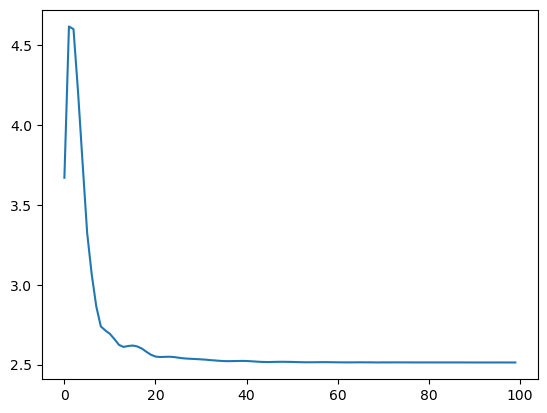

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot all_losses
sns.lineplot(categorical_loss)

<Axes: >

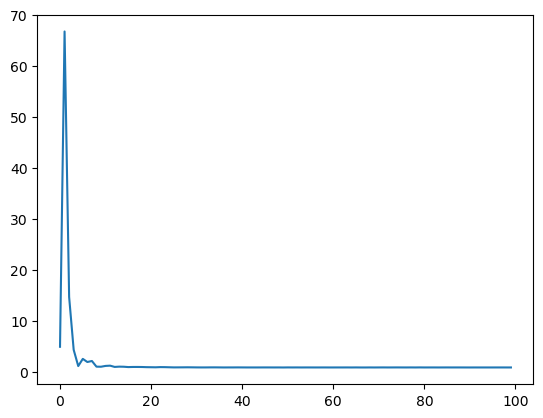

In [98]:
sns.lineplot(numeric_loss)

<Axes: >

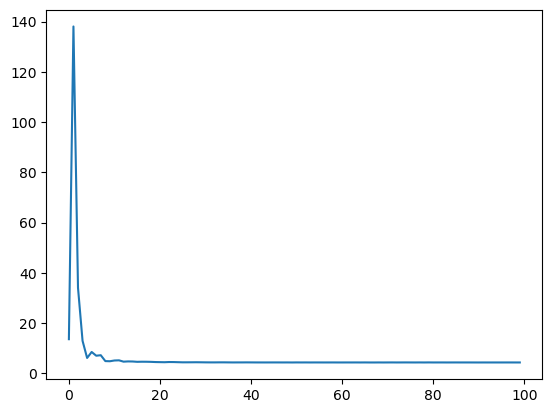

In [99]:
sns.lineplot(total_loss)

In [101]:
total_loss.min()

Array(4.2578464, dtype=float32)

In [ ]:
def replace_nans_with_zeros(n):
    x = has_nans
    mask = jnp.isnan(x)
    return jnp.where(mask, n, x)


replace_nans_with_zeros(has_nans)
jax.grad(replace_nans_with_zeros)(0.0)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (9,).

In [ ]:
def safe_for_grad_log(x):
    return jnp.log(jnp.where(x > 0.0, x, 1.0))


safe_for_grad_log(0.0)  # ==> 0.  # Ok
jax.grad(safe_for_grad_log)(0.0)  #  ==> 0.  # Ok

Array(0., dtype=float32, weak_type=True)

In [ ]:
jnp.where(mask, arr, 0.0)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
jnp.where(
    arr == float("nan"),
)

TypeError: where requires ndarray or scalar arguments, got <class 'NoneType'> at position 2.